## Title: Sentiment Analysis in Social Media Text using Neural Network

#### Description:
Train:
- RNN
- LSTM 
- biLSTM
- Two Layer biLSTM
- Two Layer biLSTM + 0.2 Dropout
- Two Layer biLSTM + 0.2 Dropout + Batch Normalization

### Table of Content

* [Introduction](#intro)
    * [Environment Set-up](#setup)
    * [Define function for learning rate plot](#define_plot)
    * [Load pre-trained word2vec model](#load_word2vec)
    * [Load dataset](#load_dataset)
    * [Remove possible empty comment(s)](#remove_empty)
    <br>
* [Word Embedding](#word_embedding)
    * [Tokenize each comments](#tokenize)
    * [Convert text to number](#text_number)
    * [Word2Vec matrix](#word2vec_matrix)
    * [Categorical target conversion](#convert_target)
    * [Class to binary conversion](#convert_class)
    * [Prepare one-hot encoding word matrix](#prepare_one_hot)
    <br>
* [Neural Network Models](#neural_network)
    * [Recurrent Neural Network (RNN)](#rnn)
    * [Long-Short Term Memory (LSTM)](#lstm)
    * [Bidirectional Long-Short Term Memory (biLSTM)](#bilstm)
    * [Two Layer Bidirectional Long-Short Term Memory (biLSTM)](#two_bilstm)
    * [Two Layer Bidirectional Long-Short Term Memory (biLSTM) + dropout 0.2](#two_bilstm_02)
    * [Two Layer Bidirectional Long-Short Term Memory (biLSTM) + dropout 0.5](#two_bilstm_05)
    * [Two Layer Bidirectional Long-Short Term Memory (biLSTM) + dropout 0.7](#two_bilstm_07)
    * [Two Layer Bidirectional Long-Short Term Memory (biLSTM) + dropout 0.2 + batch](#proposed)

#### Set-up Environment <a class="anchor" id="setup"></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow_addons as tfa
import gensim
from gensim.models import Word2Vec
from keras.preprocessing.text import one_hot, Tokenizer
import tqdm
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

import tensorflow as tf
import os

#### Define function for learning rate plot <a class="anchor" id="define_plot"></a>

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

#### Load pre-trained word2vec model <a class="anchor" id="load_word2vec"></a>

In [3]:
model = Word2Vec.load("../w2v/no_emoji_30_epochs_week5.w2v")

#### Load dataset <a class="anchor" id="load_dataset"></a>

In [4]:
test = pd.read_csv('test_emoji.csv')
df_test = pd.DataFrame(test)

train = pd.read_csv('train_emoji.csv')
df_train = pd.DataFrame(train)

val = pd.read_csv('val_emoji.csv')
df_val = pd.DataFrame(val)

texts = pd.read_csv('../3 classes/facebook_health_cases (all).csv')
df = pd.DataFrame(texts)
df.head()

,date,text,sentiment,processed,normalized,check,check_stop
0,20210221,#dsnr salam dato.. lebih kurang 15km dari ruma...,negative,salam dato lebih kurang km dari rumah ke kila...,salam dato lebih kurang km dari rumah ke kilan...,salam dato lebih kurang kkm dari rumah ke kila...,kurang kkm rumah ke kilang pkp pkb pkpp tidak ...
1,20210204,#noorhishamabdullah you’re not dr.fauci materi...,negative,you re not dr fauci material you re just pn gr...,you re not dr fauci material you re just pun g...,you re not dr fauci material you re just pun g...,not fauci material grabmart boy
2,20210130,#share dan #like page #the_information_news un...,neutral,dan page untuk mendapatkan khabar berita yang ...,dan page untuk mendapatkan khabar berita yang ...,dan page untuk mendapatkan khabar berita yang ...,page khabar berita saudara patani selatan thai...
3,20210202,1 dunia sedang & terus diperbodohkan dgn agend...,negative,satu dunia sedang and terus diperbodohkan dgn ...,satu dunia sedang and terus diperbodohkan deng...,satu dunia sedang and terus diperbodohkan deng...,dunia diperbodohkan agenda yahudi ekonomi duni...
4,20210206,1 hari sy harap angka nie turun single digit m...,positive,satu hari sy harap angka nie turun single digi...,satu hari sy harap angka ini turun single digi...,satu hari sy harap angka ini turun single digi...,harap angka turun single digit capai zero case...


#### Remove possible empty comment(s) <a class="anchor" id="remove_empty"></a>

In [5]:
# remove possible empty text cell
df = df[['check_stop', 'sentiment']]

print("before cleaned: ", df.shape)
df['check_stop'].replace('', np.nan, inplace=True)
df = df.dropna()
df = df.reset_index(drop=True)
print("After: ", df.shape)

before cleaned:  (7907, 2)
After:  (7905, 2)


### Word Embedding <a class="anchor" id="word_embedding"></a>

In this section, word embedding will be prepared. There are two different types of word embedding will be prepared here: 
- Word2vec will be used as weight matrix in embedding layer in neural network layer. 
- One-hot encoding word vector as input to neural network 

#### Tokenize each comments <a class="anchor" id="tokenize"></a>

In [6]:
tokenize_text = df['check_stop'].apply(lambda x: x.split())

#### Convert text to number  <a class="anchor" id="text_number"></a>

[Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#fit_on_texts):
> Updates internal vocabulary based on a list of texts.
In the case where texts contains lists, we assume each entry of the lists to be a token.

- Each word in tokenize_text will be rearranged in dictionary item variable with arrangement from most frequently appear word to least appeared words. 
- Each word will be assigned to an integer that can represent the word, hence each word shall have unique number.

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenize_text)

#### Word2Vec matrix   <a class="anchor" id="word2vec_matrix"></a>

- Convert each word in tokenize_text to corresponding value in word2vec model 

Variables:
- voacb_size: contain number of unique words in dataset
- error_count: contain number of word(s) in current dataset that missing in word2vec model
- embedding_matrix = array with size(vocab_size + 1 * 128), each row in this matrix contain weights of the words in word2vec 

In [8]:
# 转化成词向量矩阵，利用新的word2vec模型
vocab_size = len(tokenizer.word_index)
error_count=0
embedding_matrix = np.zeros((vocab_size + 1, 128))
for word, i in tokenizer.word_index.items():
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]
    else:
        error_count += 1

inspect the number of word(s) missing in word2vec, in this case, we have none

In [9]:
error_count

0

Overview of embedding matrix 😎

In [10]:
embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.62872031e-01, -4.18042764e-04, -4.52394694e-01, ...,
         8.39686692e-02,  2.78790563e-01,  5.80404282e-01],
       [-6.51707351e-01,  3.76401782e-01, -4.18396175e-01, ...,
         1.41281709e-01,  3.50653052e-01,  9.47910190e-01],
       ...,
       [-1.18422797e-02,  3.49949636e-02,  1.94209423e-02, ...,
         8.95177014e-03,  7.48859392e-03,  2.72510685e-02],
       [-5.66299306e-03,  1.42519949e-02,  1.16926571e-02, ...,
         1.17878104e-02,  8.84990022e-03,  1.76386032e-02],
       [-3.11119203e-03,  1.40225505e-02,  1.50357643e-02, ...,
         7.57448794e-03,  3.70327896e-03,  1.97595917e-02]])

#### Categorical target conversion   <a class="anchor" id="convert_target"></a>

*cat.codes* is a function from library Panda that convert categorical value to numeric value. In this project, the target values that has been converted are:
- negative -> 0
- neutral -> 1
- positive -> 2

In [11]:
df_test['sentiment'] = pd.Categorical(df_test['sentiment'])
df_test['sentiment'] = df_test.sentiment.cat.codes

df_train['sentiment'] = pd.Categorical(df_train['sentiment'])
df_train['sentiment'] = df_train.sentiment.cat.codes

df_val['sentiment'] = pd.Categorical(df_val['sentiment'])
df_val['sentiment'] = df_val.sentiment.cat.codes

#### Class to binary conversion   <a class="anchor" id="convert_class"></a>

to_categorical():
> Converts a class vector (integers) to binary class matrix.

for example:<br>
negative -> 0 (in previous step by *cat.codes*) -> [1 0 0] 

We can use the concept of [one-hot encoding] (https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) to understand this. 

In [12]:
y_test = df_test['sentiment']
y_train = df_train['sentiment']
y_val = df_val['sentiment']

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [13]:
tokenize_train = df_train['check_stop'].apply(lambda x: x.split())
tokenize_test = df_test['check_stop'].apply(lambda x: x.split())
tokenize_val = df_val['check_stop'].apply(lambda x: x.split())


sequence = tokenizer.texts_to_sequences(x_train)
traintitle = pad_sequences(sequence, maxlen=100)
sequence = tokenizer.texts_to_sequences(x_val)
valtitle = pad_sequences(sequence, maxlen=100)
sequence = tokenizer.texts_to_sequences(x_test)
testtitle = pad_sequences(sequence, maxlen=100)

### Neural Network Models   <a class="anchor" id="neural_network"></a>

In this section, several neural networks will be build and train to compare with the preformance of proposed neural network.

* [Recurrent Neural Network (RNN)](#rnn)
* [Long-Short Term Memory (LSTM)](#lstm)
* [Bidirectional Long-Short Term Memory (biLSTM)](#bilstm)
* [Two Layer Bidirectional Long-Short Term Memory (biLSTM)](#two_bilstm)
* [Two Layer Bidirectional Long-Short Term Memory (biLSTM) + dropout 0.2](#two_bilstm_02)
* [Two Layer Bidirectional Long-Short Term Memory (biLSTM) + dropout 0.5](#two_bilstm_05)
* [Two Layer Bidirectional Long-Short Term Memory (biLSTM) + dropout 0.7](#two_bilstm_07)
* [Two Layer Bidirectional Long-Short Term Memory (biLSTM) + dropout 0.2 + batch](#proposed)

#### Recurrent Neural Network   <a class="anchor" id="rnn"></a>

Recurrent neural network (RNN) is a type of neural network where each input words are associated with certain time step [(Abdul-Mageed & Ungar, 2017)](https://aclanthology.org/P17-1067/), which able to form a short term memory to remember the previous words [(Tomas, 2010)](https://arxiv.org/abs/1310.4546). The RNN cells are linked with each other. Author [Xu (et al., 2019)](https://ieeexplore.ieee.org/document/8684825) has mentioned in paper that traditional neural network, like feedforward neural network is in effective in text analysis because it does not imposed sequence learning in text. RNN is a sequence learning model that able to learn text sequence [(Xu et al., 2019)](https://ieeexplore.ieee.org/document/8684825). 

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=128,
        input_length=100,
        weights=[embedding_matrix]),
        #embeddings_regularizer = tf.keras.regularizers.L2(0.01),
        # Use masking to handle the variable sequence lengths
        #mask_zero=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(3)
])

In [23]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy',
                        tfa.metrics.F1Score(num_classes= 3, name = 'micro_f1_score', average='micro'),
                        tfa.metrics.F1Score(num_classes= 3, name = 'macro_f1_score', average='macro')])

In [24]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_macro_f1_score',
                                                 factor= 0.1,
                                                 patience= 30,
                                                 verbose= 1,
                                                 min_lr= 0.00001)

#file_path = "cnn_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_path = "training_1/w2v_simple_rnn_no_emoji.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
#model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)
model_chkpt = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_macro_f1_score', 
                                                 save_weights_only=True,
                                                 verbose=1, save_best_only=True, mode='max')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_macro_f1_score', patience = 45)

In [25]:
history = model.fit(traintitle, y_train, epochs=100,
                    validation_data=(valtitle, y_val),
                    shuffle=True,
                    batch_size=32,
                    callbacks = [early_stopping_callback, reduce_lr, model_chkpt])

Epoch 1/100
223/223 [==============================] - 12s 43ms/step - loss: 0.9965 - accuracy: 0.5748 - micro_f1_score: 0.5748 - macro_f1_score: 0.3438 - val_loss: 0.9406 - val_accuracy: 0.6041 - val_micro_f1_score: 0.6041 - val_macro_f1_score: 0.4556

Epoch 00001: val_macro_f1_score improved from -inf to 0.45559, saving model to training_1\w2v_rnn_no_emoji.ckpt
Epoch 2/100
223/223 [==============================] - 9s 42ms/step - loss: 0.8414 - accuracy: 0.7114 - micro_f1_score: 0.7114 - macro_f1_score: 0.5162 - val_loss: 0.9353 - val_accuracy: 0.6041 - val_micro_f1_score: 0.6041 - val_macro_f1_score: 0.4443

Epoch 00002: val_macro_f1_score did not improve from 0.45559
Epoch 3/100
223/223 [==============================] - 9s 38ms/step - loss: 0.7958 - accuracy: 0.7173 - micro_f1_score: 0.7173 - macro_f1_score: 0.5175 - val_loss: 0.8454 - val_accuracy: 0.6701 - val_micro_f1_score: 0.6701 - val_macro_f1_score: 0.5058

Epoch 00003: val_macro_f1_score improved from 0.45559 to 0.50578, s

(0.0, 1.5690024379640817)

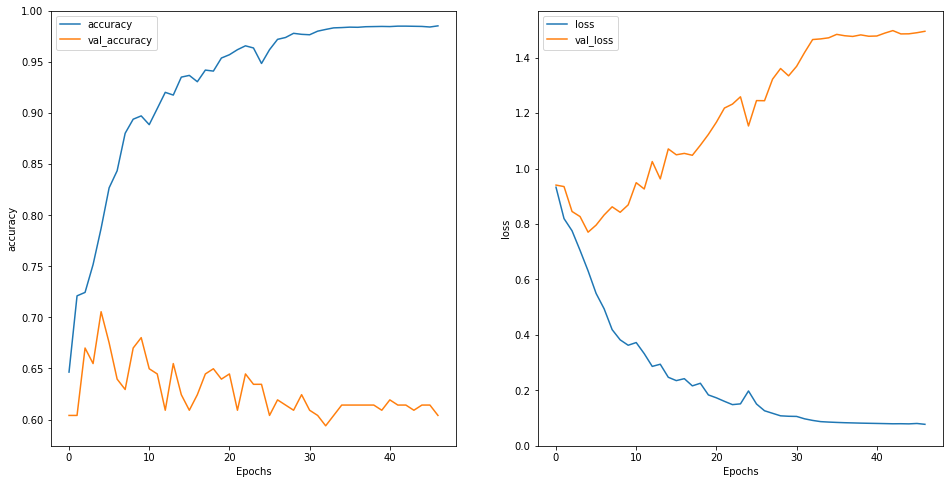

In [26]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

(0.0, 1.0080920234322548)

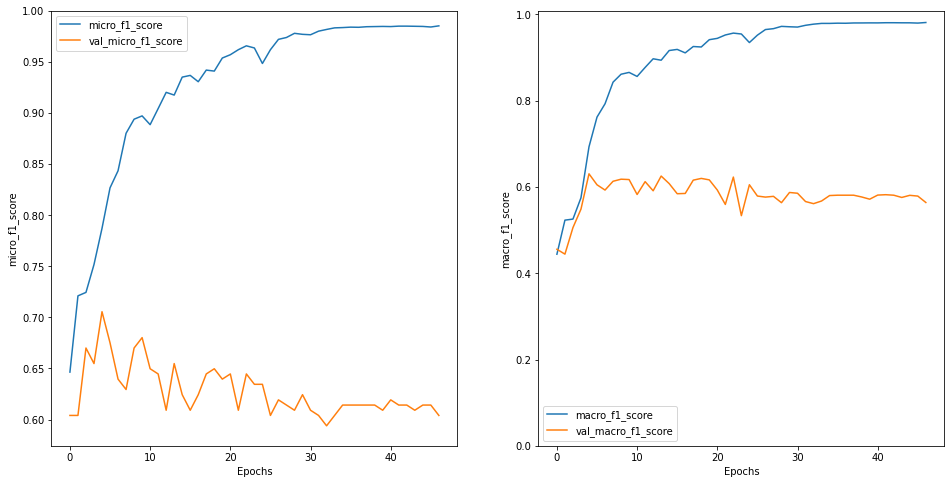

In [27]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'micro_f1_score')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'macro_f1_score')
plt.ylim(0,None)

In [28]:
model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 0s 7ms/step - loss: 0.7128 - accuracy: 0.7239 - micro_f1_score: 0.7239 - macro_f1_score: 0.6115
Test Loss: 0.7127619385719299
Test Accuracy: 0.7239057421684265
Micro F1-Score: 0.7239057421684265
Macro F1-Score: 0.6114962697029114


#### Long-Short Term Memory (LSTM) <a class="anchor" id="lstm"></a>

However, RNN can easily encounter gradient vanish or explode [(Haozheng et al., 2018)](https://github.com/NiHaozheng/NLP-Project). Hence, Long Short-Term Memory is proposed [(Sepp Hochreiter, 1997)](https://dl.acm.org/doi/10.1162/neco.1997.9.8.1735). LSTM is upgraded version of RNN with additions of output gate (o), forget gate (f) and a memory cell in RNN cell [(Xu et al., 2019)](https://ieeexplore.ieee.org/document/8684825).

The LSTM network is made up of cells and gates. The cells in LSTM also called memory cell, where it stores the input or forgot irrelevant value based on training. The gates, however, control if the erase, read and write operation on memory cell. There are total three gates in LSTM network, namely input gate, forget gate and output gate. 

Neural network has proven by some author such as [Paliwal(et al., 2018)](https://ieeexplore.ieee.org/document/8597358) that can improve the result significantly. Long Short-Term Memory is a type of recurrent neural network (RNN) that able to learn and predict the sequence of words in a sentence. In simple word, LSTM added memory cell in RNN. LSTM is a very well-known technique in speech recognition and language translation. LSTM alone have various types of architecture, such as Vanilla LSTM which contain single LSTM layer only, which make it the simplest LSTM architecture; or Bidirectional LSTM that learned input text sequences with both forward and backward method, and there are many more types of LSTM. 

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=128,
        input_length=100,
        weights=[embedding_matrix]),
        #embeddings_regularizer = tf.keras.regularizers.L2(0.01),
        # Use masking to handle the variable sequence lengths
        #mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(3)
])

In [15]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy',
                        tfa.metrics.F1Score(num_classes= 3, name = 'micro_f1_score', average='micro'),
                        tfa.metrics.F1Score(num_classes= 3, name = 'macro_f1_score', average='macro')])

In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_macro_f1_score',
                                                 factor= 0.1,
                                                 patience= 20,
                                                 verbose= 1,
                                                 min_lr= 0.00001)

#file_path = "cnn_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_path = "training_1/w2v_simple_lstm_no_emoji.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
#model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)
model_chkpt = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_macro_f1_score', 
                                                 save_weights_only=True,
                                                 verbose=1, save_best_only=True, mode='max')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_macro_f1_score', patience = 45)

In [17]:
history = model.fit(traintitle, y_train, epochs=100,
                    validation_data=(valtitle, y_val),
                    shuffle=True,
                    batch_size=32,
                    callbacks = [early_stopping_callback, reduce_lr, model_chkpt])

Epoch 1/100
223/223 [==============================] - 21s 78ms/step - loss: 0.9974 - accuracy: 0.5805 - micro_f1_score: 0.5805 - macro_f1_score: 0.2848 - val_loss: 0.9178 - val_accuracy: 0.6396 - val_micro_f1_score: 0.6396 - val_macro_f1_score: 0.4837

Epoch 00001: val_macro_f1_score improved from -inf to 0.48369, saving model to training_1\w2v_simple_lstm_no_emoji.ckpt
Epoch 2/100
223/223 [==============================] - 16s 70ms/step - loss: 0.8272 - accuracy: 0.7246 - micro_f1_score: 0.7246 - macro_f1_score: 0.5280 - val_loss: 0.8648 - val_accuracy: 0.6701 - val_micro_f1_score: 0.6701 - val_macro_f1_score: 0.5086

Epoch 00002: val_macro_f1_score improved from 0.48369 to 0.50858, saving model to training_1\w2v_simple_lstm_no_emoji.ckpt
Epoch 3/100
223/223 [==============================] - 15s 67ms/step - loss: 0.7352 - accuracy: 0.7581 - micro_f1_score: 0.7581 - macro_f1_score: 0.5607 - val_loss: 0.7879 - val_accuracy: 0.6650 - val_micro_f1_score: 0.6650 - val_macro_f1_score: 0.5


Epoch 00025: val_macro_f1_score did not improve from 0.66286
Epoch 26/100
223/223 [==============================] - 16s 73ms/step - loss: 0.0642 - accuracy: 0.9903 - micro_f1_score: 0.9903 - macro_f1_score: 0.9879 - val_loss: 1.3906 - val_accuracy: 0.6548 - val_micro_f1_score: 0.6548 - val_macro_f1_score: 0.6287

Epoch 00026: val_macro_f1_score did not improve from 0.66286
Epoch 27/100
223/223 [==============================] - 15s 66ms/step - loss: 0.0627 - accuracy: 0.9899 - micro_f1_score: 0.9899 - macro_f1_score: 0.9873 - val_loss: 1.3992 - val_accuracy: 0.6447 - val_micro_f1_score: 0.6447 - val_macro_f1_score: 0.6236

Epoch 00027: val_macro_f1_score did not improve from 0.66286
Epoch 28/100
223/223 [==============================] - 15s 66ms/step - loss: 0.0661 - accuracy: 0.9895 - micro_f1_score: 0.9895 - macro_f1_score: 0.9865 - val_loss: 1.4107 - val_accuracy: 0.6447 - val_micro_f1_score: 0.6447 - val_macro_f1_score: 0.6242

Epoch 00028: val_macro_f1_score did not improve fro

(0.0, 1.6219585515558719)

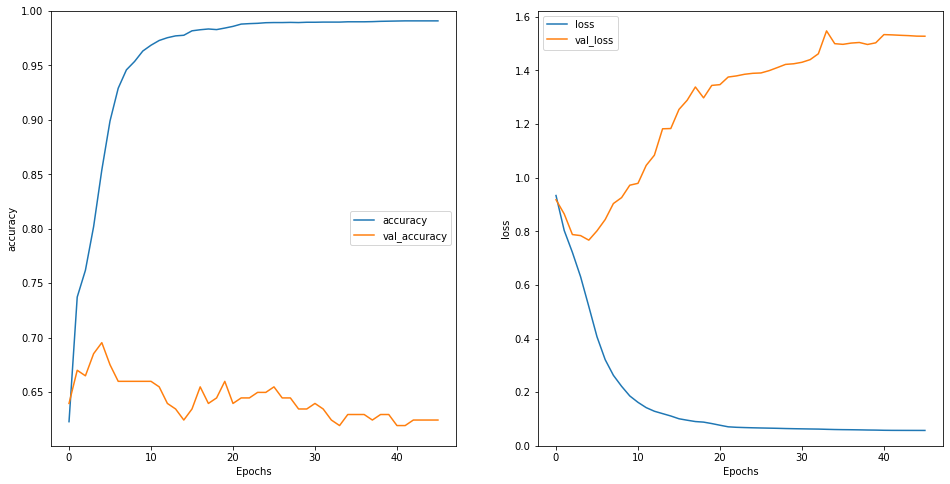

In [18]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

(0.0, 1.0178500220179558)

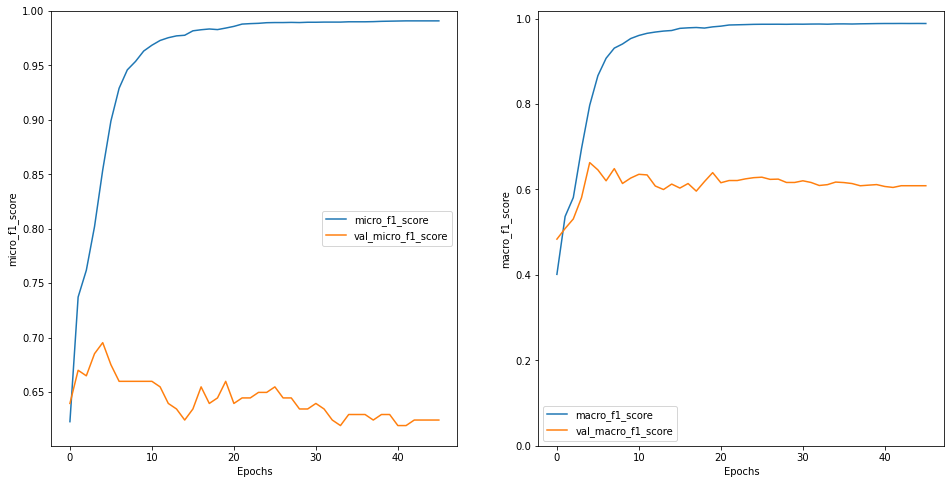

In [19]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'micro_f1_score')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'macro_f1_score')
plt.ylim(0,None)

In [20]:
#model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 0s 15ms/step - loss: 1.3514 - accuracy: 0.6768 - micro_f1_score: 0.6768 - macro_f1_score: 0.6479
Test Loss: 1.3513829708099365
Test Accuracy: 0.6767676472663879
Micro F1-Score: 0.6767676472663879
Macro F1-Score: 0.647923469543457


In [21]:
model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 0s 15ms/step - loss: 0.6993 - accuracy: 0.7222 - micro_f1_score: 0.7222 - macro_f1_score: 0.6405
Test Loss: 0.6993167996406555
Test Accuracy: 0.7222222089767456
Micro F1-Score: 0.7222221493721008
Macro F1-Score: 0.6404528617858887


#### Bidirectional Long-Short Term Memory (biLSTM) <a class="anchor" id="bilstm"></a>

Another program arise when using LSTM is that the neural network is able to learn text sequence in forward direction only (Xu et al., 2019). Hence bidirectional-LSTM (biLSTM) is proposed by authors ([Du et al., 2020](https://iopscience.iop.org/article/10.1088/1755-1315/440/3/032115); [(Xu et al., 2019)](https://ieeexplore.ieee.org/document/8684825)). With biLSTM, neural network is able to capture pattern of text in forward and backward direction. 
Unlike LSTM, biLSTM (bidirectional Long Short-Term Memory) have two later of LSTM hidden layer as in Figure 2.4 biLSTM illustration by [Xu(et al., 2019)](https://ieeexplore.ieee.org/document/8684825). In other words, it is a bidirectional RNN with LSTM units. One layer of LSTM take fed input sequence in forward order while another fed input sequence to neural network in backward order. By feeding data in two directions, model can capture surrounding inputs better and learn faster than LSTM.


In [73]:
REGULARIZER = tf.keras.regularizers.L2(0.01)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=128,
        input_length=100,
        weights=[embedding_matrix],
        embeddings_regularizer=REGULARIZER),
        #embeddings_regularizer = tf.keras.regularizers.L2(0.01),
        # Use masking to handle the variable sequence lengths
        #mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(3)
])

In [74]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy',
                        tfa.metrics.F1Score(num_classes= 3, name = 'micro_f1_score', average='micro'),
                        tfa.metrics.F1Score(num_classes= 3, name = 'macro_f1_score', average='macro')])

In [75]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 128)          1551360   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 195       
Total params: 1,658,627
Trainable params: 1,658,627
Non-trainable params: 0
_________________________________________________________________


In [76]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_macro_f1_score',
                                                 factor= 0.1,
                                                 patience= 20,
                                                 verbose= 1,
                                                 min_lr= 0.00001)

#file_path = "cnn_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_path = "training_1/w2v_one_layer_bilstm_no_emoji.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
#model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)
model_chkpt = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_macro_f1_score', 
                                                 save_weights_only=True,
                                                 verbose=1, save_best_only=True, mode='max')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_macro_f1_score', patience = 45)

In [77]:
history = model.fit(traintitle, y_train, epochs=100,
                    validation_data=(valtitle, y_val),
                    shuffle=True,
                    batch_size=32,
                    callbacks = [early_stopping_callback, reduce_lr, model_chkpt])

Epoch 1/100
223/223 [==============================] - 43s 154ms/step - loss: 129.7921 - accuracy: 0.5490 - micro_f1_score: 0.5490 - macro_f1_score: 0.2709 - val_loss: 57.9501 - val_accuracy: 0.6142 - val_micro_f1_score: 0.6142 - val_macro_f1_score: 0.4618

Epoch 00001: val_macro_f1_score improved from -inf to 0.46180, saving model to training_1\w2v_one_layer_lstm_no_emoji.ckpt
Epoch 2/100
223/223 [==============================] - 36s 162ms/step - loss: 47.9285 - accuracy: 0.7280 - micro_f1_score: 0.7280 - macro_f1_score: 0.5245 - val_loss: 26.9040 - val_accuracy: 0.6294 - val_micro_f1_score: 0.6294 - val_macro_f1_score: 0.4722

Epoch 00002: val_macro_f1_score improved from 0.46180 to 0.47220, saving model to training_1\w2v_one_layer_lstm_no_emoji.ckpt
Epoch 3/100
223/223 [==============================] - 34s 154ms/step - loss: 22.8170 - accuracy: 0.7222 - micro_f1_score: 0.7222 - macro_f1_score: 0.5241 - val_loss: 13.9413 - val_accuracy: 0.5787 - val_micro_f1_score: 0.5787 - val_mac


Epoch 00024: val_macro_f1_score did not improve from 0.70737
Epoch 25/100
223/223 [==============================] - 32s 145ms/step - loss: 0.3504 - accuracy: 0.9461 - micro_f1_score: 0.9461 - macro_f1_score: 0.9300 - val_loss: 0.9738 - val_accuracy: 0.6853 - val_micro_f1_score: 0.6853 - val_macro_f1_score: 0.6397

Epoch 00025: val_macro_f1_score did not improve from 0.70737
Epoch 26/100
223/223 [==============================] - 32s 145ms/step - loss: 0.3164 - accuracy: 0.9539 - micro_f1_score: 0.9539 - macro_f1_score: 0.9408 - val_loss: 0.9713 - val_accuracy: 0.6751 - val_micro_f1_score: 0.6751 - val_macro_f1_score: 0.6268

Epoch 00026: val_macro_f1_score did not improve from 0.70737
Epoch 27/100
223/223 [==============================] - 32s 143ms/step - loss: 0.3054 - accuracy: 0.9546 - micro_f1_score: 0.9546 - macro_f1_score: 0.9418 - val_loss: 0.9747 - val_accuracy: 0.6701 - val_micro_f1_score: 0.6701 - val_macro_f1_score: 0.6206

Epoch 00027: val_macro_f1_score did not improve 

(0.0, 104.88777344971895)

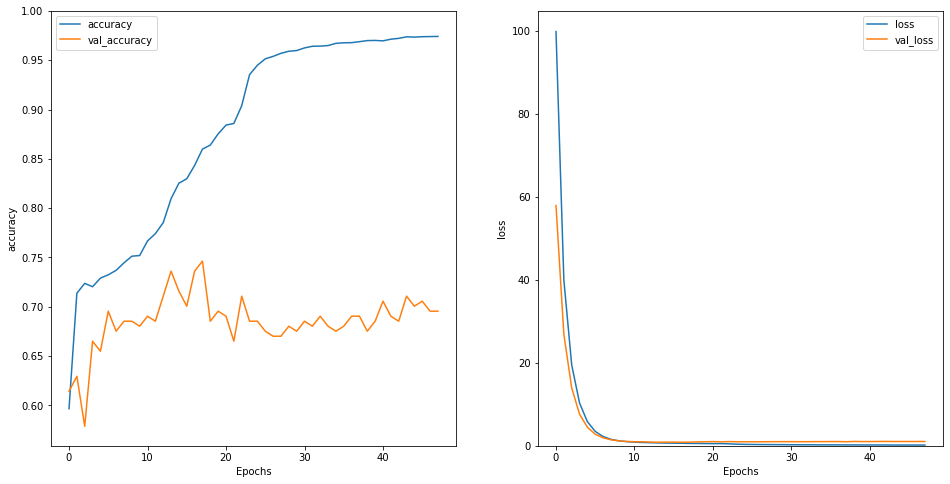

In [78]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

(0.0, 0.9969871208071709)

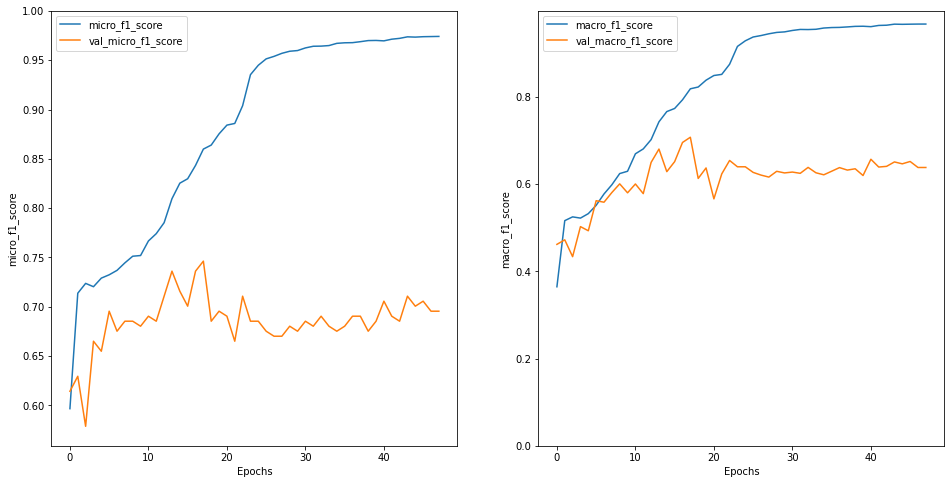

In [79]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'micro_f1_score')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'macro_f1_score')
plt.ylim(0,None)

In [80]:
#model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 1s 38ms/step - loss: 0.8576 - accuracy: 0.7340 - micro_f1_score: 0.7340 - macro_f1_score: 0.6710
Test Loss: 0.8575960993766785
Test Accuracy: 0.7340067625045776
Micro F1-Score: 0.7340067625045776
Macro F1-Score: 0.6709898114204407


In [81]:
model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 1s 39ms/step - loss: 0.8034 - accuracy: 0.7492 - micro_f1_score: 0.7492 - macro_f1_score: 0.6787
Test Loss: 0.803426206111908
Test Accuracy: 0.7491582632064819
Micro F1-Score: 0.7491582632064819
Macro F1-Score: 0.6786510944366455


#### Two Layer Bidirectional Long-Short Term Memory (biLSTM) <a class="anchor" id="two_bilstm"></a>

[Machine Learning Mastery](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/):
> One way to improve the performance a neural network is to add more layers. This might allow the model to extract and recombine higher order features embedded in the data.

In [14]:
REGULARIZER = tf.keras.regularizers.L2(0.01)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=128,
        input_length=100,
        weights=[embedding_matrix],
        embeddings_regularizer=REGULARIZER),
        #embeddings_regularizer = tf.keras.regularizers.L2(0.01),
        # Use masking to handle the variable sequence lengths
        #mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(3)
])

In [15]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy',
                        tfa.metrics.F1Score(num_classes= 3, name = 'micro_f1_score', average='micro'),
                        tfa.metrics.F1Score(num_classes= 3, name = 'macro_f1_score', average='macro')])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          1551360   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,695,747
Trainable params: 1,695,747
Non-trainable params: 0
_________________________________________________________________


In [17]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_macro_f1_score',
                                                 factor= 0.1,
                                                 patience= 20,
                                                 verbose= 1,
                                                 min_lr= 0.00001)

#file_path = "cnn_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_path = "training_1/w2v_two_layer_bilstm_no_emoji.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
#model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)
model_chkpt = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_macro_f1_score', 
                                                 save_weights_only=True,
                                                 verbose=1, save_best_only=True, mode='max')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_macro_f1_score', patience = 45)

In [18]:
history = model.fit(traintitle, y_train, epochs=100,
                    validation_data=(valtitle, y_val),
                    shuffle=True,
                    batch_size=32,
                    callbacks = [early_stopping_callback, reduce_lr, model_chkpt])

Epoch 1/100
223/223 [==============================] - 48s 165ms/step - loss: 129.7938 - accuracy: 0.5983 - micro_f1_score: 0.5983 - macro_f1_score: 0.3816 - val_loss: 57.9344 - val_accuracy: 0.6244 - val_micro_f1_score: 0.6244 - val_macro_f1_score: 0.4719

Epoch 00001: val_macro_f1_score improved from -inf to 0.47190, saving model to training_1\w2v_one_layer_lstm_no_emoji.ckpt
Epoch 2/100
223/223 [==============================] - 34s 153ms/step - loss: 47.9199 - accuracy: 0.7217 - micro_f1_score: 0.7217 - macro_f1_score: 0.5234 - val_loss: 26.9486 - val_accuracy: 0.5838 - val_micro_f1_score: 0.5838 - val_macro_f1_score: 0.4390

Epoch 00002: val_macro_f1_score did not improve from 0.47190
Epoch 3/100
223/223 [==============================] - 32s 144ms/step - loss: 22.8184 - accuracy: 0.7134 - micro_f1_score: 0.7134 - macro_f1_score: 0.5182 - val_loss: 13.8415 - val_accuracy: 0.6497 - val_micro_f1_score: 0.6497 - val_macro_f1_score: 0.4905

Epoch 00003: val_macro_f1_score improved fro


Epoch 00024: val_macro_f1_score did not improve from 0.72966
Epoch 25/100
223/223 [==============================] - 29s 130ms/step - loss: 0.3514 - accuracy: 0.9450 - micro_f1_score: 0.9450 - macro_f1_score: 0.9295 - val_loss: 0.8365 - val_accuracy: 0.7563 - val_micro_f1_score: 0.7563 - val_macro_f1_score: 0.6931

Epoch 00025: val_macro_f1_score did not improve from 0.72966
Epoch 26/100
223/223 [==============================] - 30s 136ms/step - loss: 0.3391 - accuracy: 0.9483 - micro_f1_score: 0.9483 - macro_f1_score: 0.9340 - val_loss: 0.8246 - val_accuracy: 0.7563 - val_micro_f1_score: 0.7563 - val_macro_f1_score: 0.6926

Epoch 00026: val_macro_f1_score did not improve from 0.72966
Epoch 27/100
223/223 [==============================] - 29s 130ms/step - loss: 0.3175 - accuracy: 0.9522 - micro_f1_score: 0.9522 - macro_f1_score: 0.9376 - val_loss: 0.8332 - val_accuracy: 0.7614 - val_micro_f1_score: 0.7614 - val_macro_f1_score: 0.6965

Epoch 00027: val_macro_f1_score did not improve 

(0.0, 104.87362506389618)

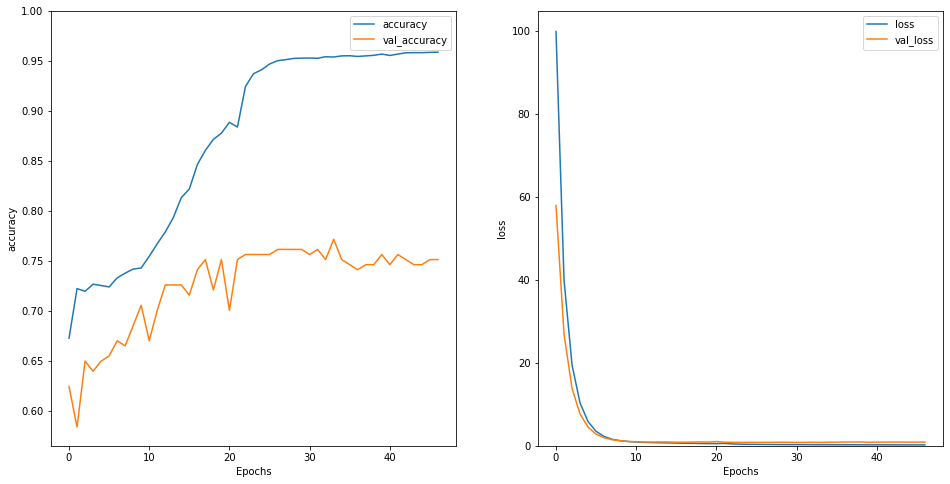

In [19]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

(0.0, 0.9725492626428605)

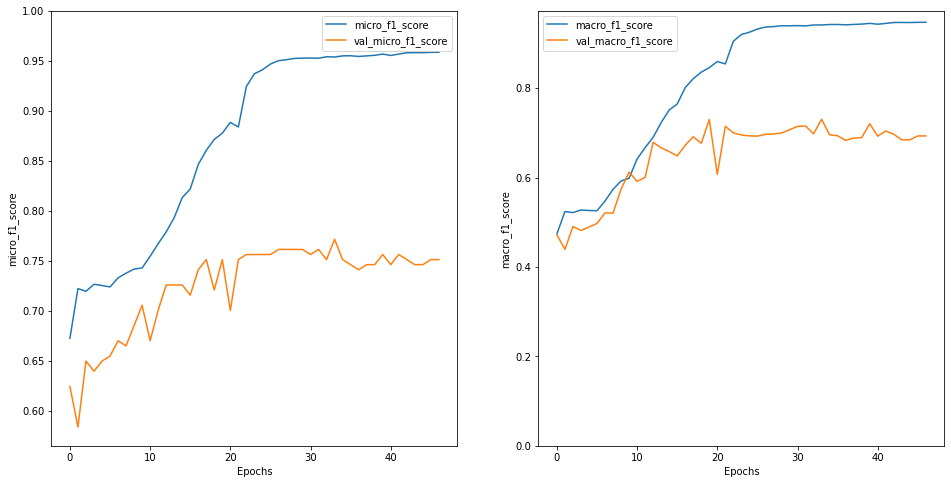

In [20]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'micro_f1_score')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'macro_f1_score')
plt.ylim(0,None)

In [21]:
#model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 1s 38ms/step - loss: 0.9507 - accuracy: 0.7205 - micro_f1_score: 0.7205 - macro_f1_score: 0.6533
Test Loss: 0.9506630301475525
Test Accuracy: 0.7205387353897095
Micro F1-Score: 0.7205387353897095
Macro F1-Score: 0.6533465385437012


In [22]:
model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 1s 38ms/step - loss: 0.8942 - accuracy: 0.7256 - micro_f1_score: 0.7256 - macro_f1_score: 0.6603
Test Loss: 0.894220232963562
Test Accuracy: 0.7255892157554626
Micro F1-Score: 0.7255892157554626
Macro F1-Score: 0.6603447794914246


#### Two Layer Bidirectional Long-Short Term Memory (biLSTM) + dropout 0.2 <a class="anchor" id="two_bilstm_02"></a>

Dropout is a types of regularization that ignore some nodes randomly in training, which changed the architecture of neural network with just a layer of dropout added [(Garbin & Zhu, 2020)](https://link.springer.com/article/10.1007/s11042-019-08453-9). With additional dropout added, training time will be increased [(Garbin & Zhu, 2020)](https://link.springer.com/article/10.1007/s11042-019-08453-9).  

In [23]:
REGULARIZER = tf.keras.regularizers.L2(0.01)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=128,
        input_length=100,
        weights=[embedding_matrix],
        embeddings_regularizer=REGULARIZER),
        #embeddings_regularizer = tf.keras.regularizers.L2(0.01),
        # Use masking to handle the variable sequence lengths
        #mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(3)
])

In [24]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy',
                        tfa.metrics.F1Score(num_classes= 3, name = 'micro_f1_score', average='micro'),
                        tfa.metrics.F1Score(num_classes= 3, name = 'macro_f1_score', average='macro')])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          1551360   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 1,695,747
Trainable params: 1,695,747
Non-trainable params: 0
____________________________________________

In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_macro_f1_score',
                                                 factor= 0.1,
                                                 patience= 20,
                                                 verbose= 1,
                                                 min_lr= 0.00001)

#file_path = "cnn_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_path = "training_1/w2v_two_layer_bilstm_02_no_emoji.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
#model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)
model_chkpt = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_macro_f1_score', 
                                                 save_weights_only=True,
                                                 verbose=1, save_best_only=True, mode='max')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_macro_f1_score', patience = 30)

In [27]:
history = model.fit(traintitle, y_train, epochs=100,
                    validation_data=(valtitle, y_val),
                    shuffle=True,
                    batch_size=32,
                    callbacks = [early_stopping_callback, reduce_lr, model_chkpt])

Epoch 1/100
223/223 [==============================] - 55s 190ms/step - loss: 129.7916 - accuracy: 0.5727 - micro_f1_score: 0.5727 - macro_f1_score: 0.3789 - val_loss: 57.9172 - val_accuracy: 0.6294 - val_micro_f1_score: 0.6294 - val_macro_f1_score: 0.4710

Epoch 00001: val_macro_f1_score improved from -inf to 0.47100, saving model to training_1\w2v_one_layer_lstm_no_emoji.ckpt
Epoch 2/100
223/223 [==============================] - 40s 179ms/step - loss: 47.9279 - accuracy: 0.7050 - micro_f1_score: 0.7050 - macro_f1_score: 0.5056 - val_loss: 26.8990 - val_accuracy: 0.6345 - val_micro_f1_score: 0.6345 - val_macro_f1_score: 0.4780

Epoch 00002: val_macro_f1_score improved from 0.47100 to 0.47798, saving model to training_1\w2v_one_layer_lstm_no_emoji.ckpt
Epoch 3/100
223/223 [==============================] - 40s 177ms/step - loss: 22.8111 - accuracy: 0.7181 - micro_f1_score: 0.7181 - macro_f1_score: 0.5198 - val_loss: 13.8719 - val_accuracy: 0.6548 - val_micro_f1_score: 0.6548 - val_mac

223/223 [==============================] - 31s 139ms/step - loss: 0.4053 - accuracy: 0.9315 - micro_f1_score: 0.9315 - macro_f1_score: 0.9089 - val_loss: 0.9144 - val_accuracy: 0.7157 - val_micro_f1_score: 0.7157 - val_macro_f1_score: 0.6774

Epoch 00025: val_macro_f1_score did not improve from 0.73651
Epoch 26/100
223/223 [==============================] - 31s 139ms/step - loss: 0.3296 - accuracy: 0.9499 - micro_f1_score: 0.9499 - macro_f1_score: 0.9352 - val_loss: 0.9026 - val_accuracy: 0.7208 - val_micro_f1_score: 0.7208 - val_macro_f1_score: 0.6798

Epoch 00026: val_macro_f1_score did not improve from 0.73651
Epoch 27/100
223/223 [==============================] - 31s 139ms/step - loss: 0.3001 - accuracy: 0.9564 - micro_f1_score: 0.9564 - macro_f1_score: 0.9446 - val_loss: 0.8956 - val_accuracy: 0.7208 - val_micro_f1_score: 0.7208 - val_macro_f1_score: 0.6751

Epoch 00027: val_macro_f1_score did not improve from 0.73651
Epoch 28/100
223/223 [==============================] - 31s 13

(0.0, 104.86492565423251)

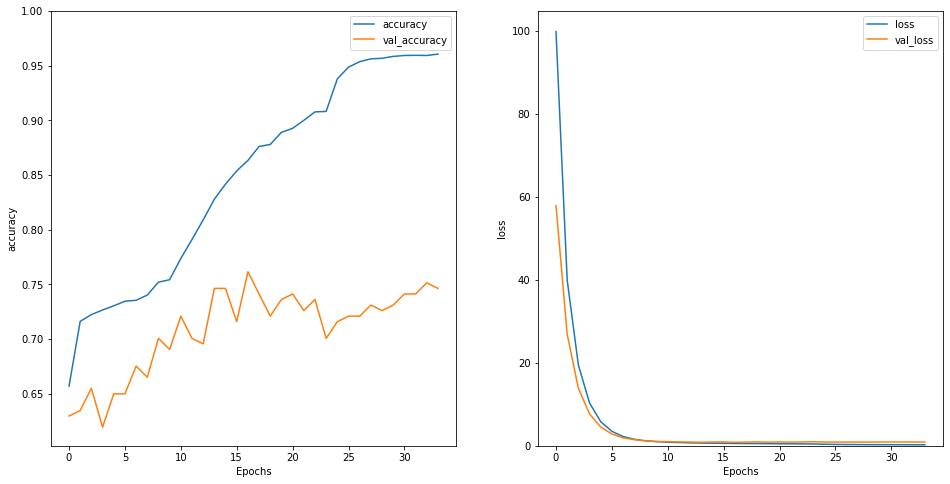

In [28]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

(0.0, 0.9747187107801437)

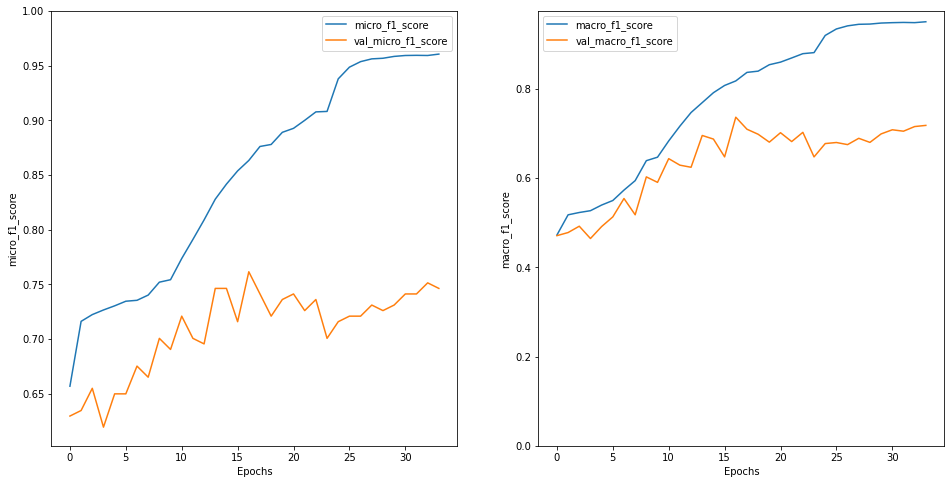

In [29]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'micro_f1_score')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'macro_f1_score')
plt.ylim(0,None)

In [30]:
#model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 1s 47ms/step - loss: 0.9616 - accuracy: 0.7138 - micro_f1_score: 0.7138 - macro_f1_score: 0.6581
Test Loss: 0.9616068601608276
Test Accuracy: 0.7138047218322754
Micro F1-Score: 0.7138047218322754
Macro F1-Score: 0.6580881476402283


In [31]:
model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 1s 41ms/step - loss: 0.8403 - accuracy: 0.7340 - micro_f1_score: 0.7340 - macro_f1_score: 0.6719
Test Loss: 0.8403355479240417
Test Accuracy: 0.7340067625045776
Micro F1-Score: 0.7340067625045776
Macro F1-Score: 0.6719077229499817


#### Two Layer Bidirectional Long-Short Term Memory (biLSTM) + dropout 0.5 <a class="anchor" id="two_bilstm_05"></a>

Different dropout rate is tested.

In [24]:
REGULARIZER = tf.keras.regularizers.L2(0.01)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=128,
        input_length=100,
        weights=[embedding_matrix],
        embeddings_regularizer=REGULARIZER),
        #embeddings_regularizer = tf.keras.regularizers.L2(0.01),
        # Use masking to handle the variable sequence lengths
        #mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(3)
])

In [25]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy',
                        tfa.metrics.F1Score(num_classes= 3, name = 'micro_f1_score', average='micro'),
                        tfa.metrics.F1Score(num_classes= 3, name = 'macro_f1_score', average='macro')])

In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_macro_f1_score',
                                                 factor= 0.1,
                                                 patience= 30,
                                                 verbose= 1,
                                                 min_lr= 0.00001)

#file_path = "cnn_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_path = "training_1/w2v_two_layer_bilstm_05_no_emoji.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
#model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)
model_chkpt = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_macro_f1_score', 
                                                 save_weights_only=True,
                                                 verbose=1, save_best_only=True, mode='max')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_macro_f1_score', patience = 40)

In [27]:
history = model.fit(traintitle, y_train, epochs=100,
                    validation_data=(valtitle, y_val),
                    shuffle=True,
                    batch_size=32,
                    callbacks = [early_stopping_callback, reduce_lr, model_chkpt])

Epoch 1/100
223/223 [==============================] - 54s 187ms/step - loss: 129.7970 - accuracy: 0.5893 - micro_f1_score: 0.5893 - macro_f1_score: 0.3565 - val_loss: 57.9344 - val_accuracy: 0.6193 - val_micro_f1_score: 0.6193 - val_macro_f1_score: 0.4630

Epoch 00001: val_macro_f1_score improved from -inf to 0.46304, saving model to training_1\w2v_one_layer_lstm_no_emoji.ckpt
Epoch 2/100
223/223 [==============================] - 36s 163ms/step - loss: 47.9226 - accuracy: 0.7066 - micro_f1_score: 0.7066 - macro_f1_score: 0.5110 - val_loss: 26.8716 - val_accuracy: 0.6599 - val_micro_f1_score: 0.6599 - val_macro_f1_score: 0.5001

Epoch 00002: val_macro_f1_score improved from 0.46304 to 0.50006, saving model to training_1\w2v_one_layer_lstm_no_emoji.ckpt
Epoch 3/100
223/223 [==============================] - 38s 168ms/step - loss: 22.8014 - accuracy: 0.7290 - micro_f1_score: 0.7290 - macro_f1_score: 0.5256 - val_loss: 13.8667 - val_accuracy: 0.6447 - val_micro_f1_score: 0.6447 - val_mac

(0.0, 104.871956589818)

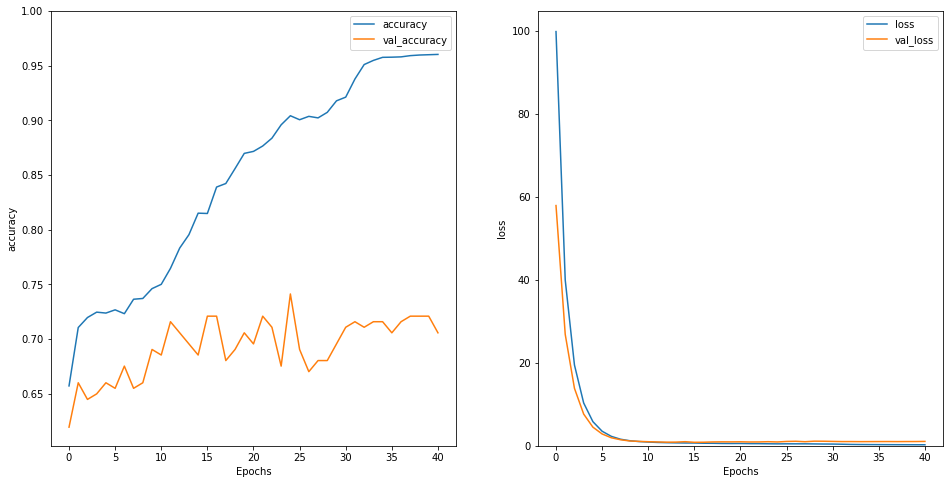

In [28]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

(0.0, 0.9755136087536812)

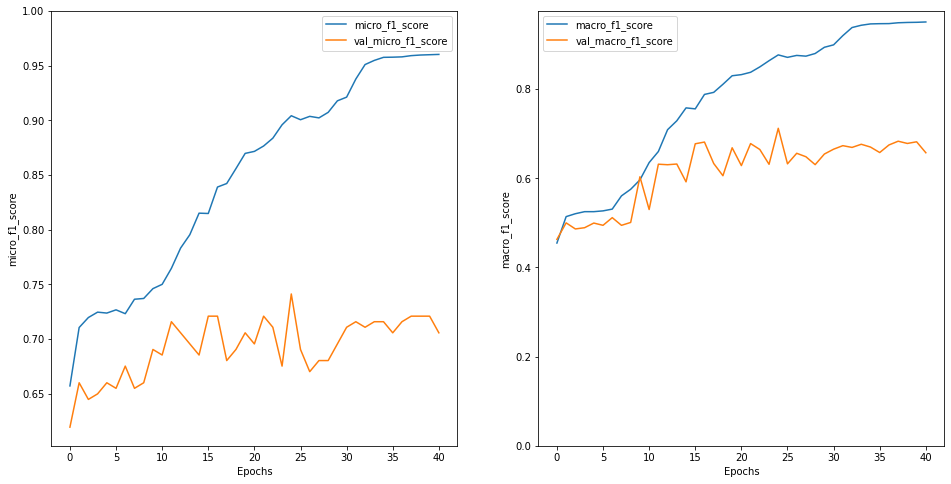

In [29]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'micro_f1_score')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'macro_f1_score')
plt.ylim(0,None)

In [30]:
#model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 1s 46ms/step - loss: 0.9621 - accuracy: 0.7340 - micro_f1_score: 0.7340 - macro_f1_score: 0.6652
Test Loss: 0.9621493816375732
Test Accuracy: 0.7340067625045776
Micro F1-Score: 0.7340067625045776
Macro F1-Score: 0.6651656031608582


In [31]:
model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 1s 45ms/step - loss: 0.9030 - accuracy: 0.7424 - micro_f1_score: 0.7424 - macro_f1_score: 0.6761
Test Loss: 0.9029854536056519
Test Accuracy: 0.7424242496490479
Micro F1-Score: 0.7424242496490479
Macro F1-Score: 0.676068127155304


#### Two Layer Bidirectional Long-Short Term Memory (biLSTM) + dropout 0.7 <a class="anchor" id="two_bilstm_07"></a>

In [32]:
REGULARIZER = tf.keras.regularizers.L2(0.01)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=128,
        input_length=100,
        weights=[embedding_matrix],
        embeddings_regularizer=REGULARIZER),
        #embeddings_regularizer = tf.keras.regularizers.L2(0.01),
        # Use masking to handle the variable sequence lengths
        #mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(3)
])

In [33]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy',
                        tfa.metrics.F1Score(num_classes= 3, name = 'micro_f1_score', average='micro'),
                        tfa.metrics.F1Score(num_classes= 3, name = 'macro_f1_score', average='macro')])

In [34]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_macro_f1_score',
                                                 factor= 0.1,
                                                 patience= 30,
                                                 verbose= 1,
                                                 min_lr= 0.00001)

#file_path = "cnn_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_path = "training_1/w2v_two_layer_bilstm_07_no_emoji.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
#model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)
model_chkpt = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_macro_f1_score', 
                                                 save_weights_only=True,
                                                 verbose=1, save_best_only=True, mode='max')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_macro_f1_score', patience = 40)

In [35]:
history = model.fit(traintitle, y_train, epochs=100,
                    validation_data=(valtitle, y_val),
                    shuffle=True,
                    batch_size=32,
                    callbacks = [early_stopping_callback, reduce_lr, model_chkpt])

Epoch 1/100
223/223 [==============================] - 53s 182ms/step - loss: 129.7991 - accuracy: 0.5917 - micro_f1_score: 0.5917 - macro_f1_score: 0.3276 - val_loss: 57.9453 - val_accuracy: 0.5990 - val_micro_f1_score: 0.5990 - val_macro_f1_score: 0.4489

Epoch 00001: val_macro_f1_score improved from -inf to 0.44895, saving model to training_1\w2v_one_layer_lstm_no_emoji.ckpt
Epoch 2/100
223/223 [==============================] - 36s 159ms/step - loss: 47.9467 - accuracy: 0.6967 - micro_f1_score: 0.6967 - macro_f1_score: 0.5015 - val_loss: 26.9199 - val_accuracy: 0.6244 - val_micro_f1_score: 0.6244 - val_macro_f1_score: 0.4673

Epoch 00002: val_macro_f1_score improved from 0.44895 to 0.46733, saving model to training_1\w2v_one_layer_lstm_no_emoji.ckpt
Epoch 3/100
223/223 [==============================] - 37s 165ms/step - loss: 22.8269 - accuracy: 0.7214 - micro_f1_score: 0.7214 - macro_f1_score: 0.5199 - val_loss: 13.9126 - val_accuracy: 0.6294 - val_micro_f1_score: 0.6294 - val_mac

223/223 [==============================] - 38s 170ms/step - loss: 0.5766 - accuracy: 0.8680 - micro_f1_score: 0.8680 - macro_f1_score: 0.8303 - val_loss: 0.8577 - val_accuracy: 0.7411 - val_micro_f1_score: 0.7411 - val_macro_f1_score: 0.7045

Epoch 00024: val_macro_f1_score did not improve from 0.72568
Epoch 25/100
223/223 [==============================] - 38s 170ms/step - loss: 0.5646 - accuracy: 0.8683 - micro_f1_score: 0.8683 - macro_f1_score: 0.8340 - val_loss: 0.9559 - val_accuracy: 0.7411 - val_micro_f1_score: 0.7411 - val_macro_f1_score: 0.7121

Epoch 00025: val_macro_f1_score did not improve from 0.72568
Epoch 26/100
223/223 [==============================] - 40s 179ms/step - loss: 0.5526 - accuracy: 0.8775 - micro_f1_score: 0.8775 - macro_f1_score: 0.8440 - val_loss: 0.9947 - val_accuracy: 0.6853 - val_micro_f1_score: 0.6853 - val_macro_f1_score: 0.6240

Epoch 00026: val_macro_f1_score did not improve from 0.72568
Epoch 27/100
223/223 [==============================] - 42s 18

(0.0, 0.9567699417471885)

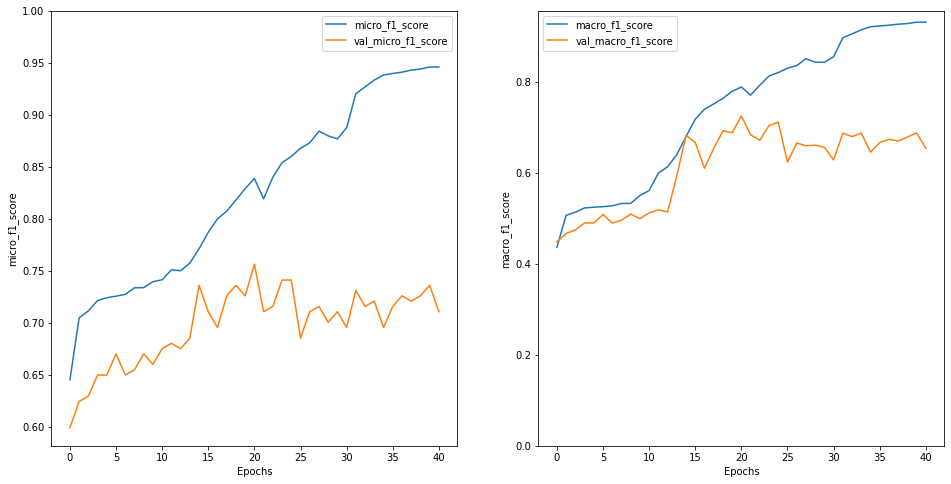

In [36]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'micro_f1_score')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'macro_f1_score')
plt.ylim(0,None)

(0.0, 104.87947296351194)

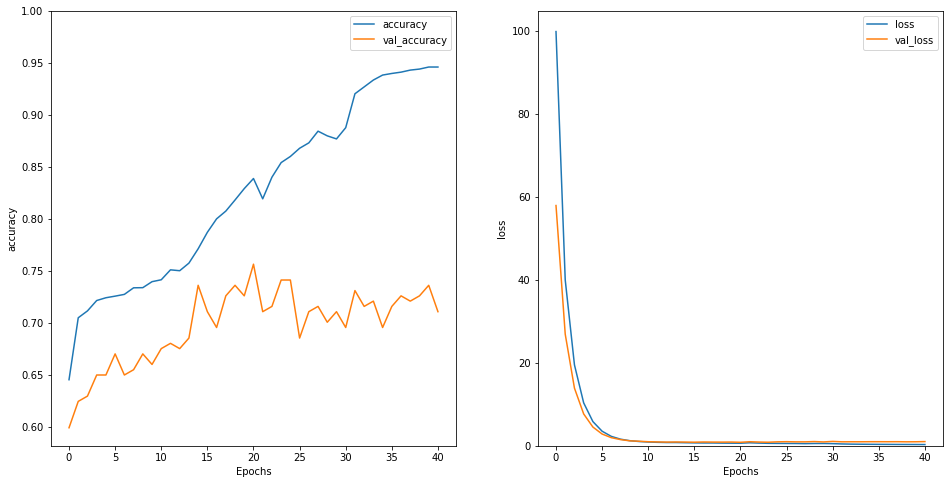

In [37]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [38]:
#model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 1s 37ms/step - loss: 0.8849 - accuracy: 0.7492 - micro_f1_score: 0.7492 - macro_f1_score: 0.6764
Test Loss: 0.8849151134490967
Test Accuracy: 0.7491582632064819
Micro F1-Score: 0.7491582632064819
Macro F1-Score: 0.6764084696769714


In [39]:
model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 1s 37ms/step - loss: 0.8414 - accuracy: 0.7340 - micro_f1_score: 0.7340 - macro_f1_score: 0.6741
Test Loss: 0.8414467573165894
Test Accuracy: 0.7340067625045776
Micro F1-Score: 0.7340067625045776
Macro F1-Score: 0.6741054058074951


#### Two Layer Bidirectional Long-Short Term Memory (biLSTM) + dropout 0.2 + batch <a class="anchor" id="proposed"></a>


Batch normalization is introduced to normalize inputs of each neural network layer, thus speed up the neural network training time [(Garbin & Zhu, 2020)](https://link.springer.com/article/10.1007/s11042-019-08453-9). Besides that, batch normalization is also able to increase model’s prediction ability by adjust stochastic value of units each batch and results in noises that act as regularizer. The noises are acted as regularizer in neural network. Hence, by using batch normalization in neural network, dropout layer or L2 regularizer should be removed or have lower rate or else it will be too much noises for the model [(Garbin & Zhu, 2020)](https://link.springer.com/article/10.1007/s11042-019-08453-9).

In [53]:
REGULARIZER = tf.keras.regularizers.L2(0.01)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=128,
        input_length=100,
        weights=[embedding_matrix],
        embeddings_regularizer=REGULARIZER),
        #embeddings_regularizer = tf.keras.regularizers.L2(0.01),
        # Use masking to handle the variable sequence lengths
        #mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(3)
])

In [54]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy',
                        tfa.metrics.F1Score(num_classes= 3, name = 'micro_f1_score', average='micro'),
                        tfa.metrics.F1Score(num_classes= 3, name = 'macro_f1_score', average='macro')])

In [55]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 128)          1551360   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 100, 128)          98816     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 3)                

In [56]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_macro_f1_score',
                                                 factor= 0.1,
                                                 patience= 20,
                                                 verbose= 1,
                                                 min_lr= 0.00001)

#file_path = "cnn_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_path = "training_1/w2v_two_layer_bilstm_02_batch_no_emoji.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
#model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)
model_chkpt = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_macro_f1_score', 
                                                 save_weights_only=True,
                                                 verbose=1, save_best_only=True, mode='max')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_macro_f1_score', patience = 30)

In [57]:
history = model.fit(traintitle, y_train, epochs=100,
                    validation_data=(valtitle, y_val),
                    shuffle=True,
                    batch_size=32,
                    callbacks = [early_stopping_callback, reduce_lr, model_chkpt])

Epoch 1/100
223/223 [==============================] - 54s 192ms/step - loss: 129.8096 - accuracy: 0.5914 - micro_f1_score: 0.5914 - macro_f1_score: 0.5070 - val_loss: 57.9915 - val_accuracy: 0.6396 - val_micro_f1_score: 0.6396 - val_macro_f1_score: 0.4790

Epoch 00001: val_macro_f1_score improved from -inf to 0.47901, saving model to training_1\w2v_one_layer_lstm_no_emoji.ckpt
Epoch 2/100
223/223 [==============================] - 42s 190ms/step - loss: 47.9875 - accuracy: 0.7196 - micro_f1_score: 0.7196 - macro_f1_score: 0.5218 - val_loss: 27.0440 - val_accuracy: 0.5888 - val_micro_f1_score: 0.5888 - val_macro_f1_score: 0.4422

Epoch 00002: val_macro_f1_score did not improve from 0.47901
Epoch 3/100
223/223 [==============================] - 39s 174ms/step - loss: 22.8997 - accuracy: 0.7182 - micro_f1_score: 0.7182 - macro_f1_score: 0.5210 - val_loss: 13.9447 - val_accuracy: 0.6497 - val_micro_f1_score: 0.6497 - val_macro_f1_score: 0.4901

Epoch 00003: val_macro_f1_score improved fro


Epoch 00024: val_macro_f1_score did not improve from 0.73945
Epoch 25/100
223/223 [==============================] - 51s 228ms/step - loss: 0.3386 - accuracy: 0.9452 - micro_f1_score: 0.9452 - macro_f1_score: 0.9282 - val_loss: 0.9576 - val_accuracy: 0.6954 - val_micro_f1_score: 0.6954 - val_macro_f1_score: 0.6447

Epoch 00025: val_macro_f1_score did not improve from 0.73945
Epoch 26/100
223/223 [==============================] - 49s 219ms/step - loss: 0.3273 - accuracy: 0.9479 - micro_f1_score: 0.9479 - macro_f1_score: 0.9348 - val_loss: 0.9628 - val_accuracy: 0.7056 - val_micro_f1_score: 0.7056 - val_macro_f1_score: 0.6582

Epoch 00026: val_macro_f1_score did not improve from 0.73945
Epoch 27/100
223/223 [==============================] - 45s 204ms/step - loss: 0.3122 - accuracy: 0.9496 - micro_f1_score: 0.9496 - macro_f1_score: 0.9346 - val_loss: 0.9617 - val_accuracy: 0.7107 - val_micro_f1_score: 0.7107 - val_macro_f1_score: 0.6624

Epoch 00027: val_macro_f1_score did not improve 

(0.0, 104.89325385093689)

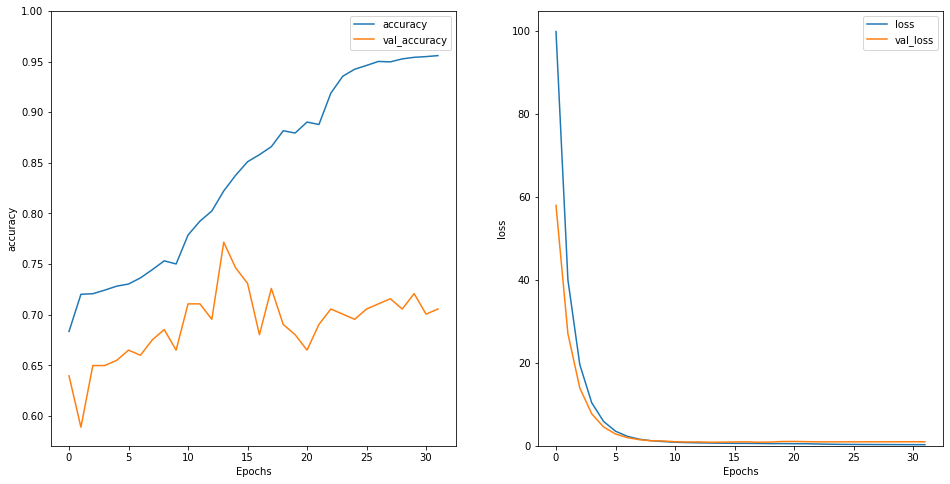

In [58]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

(0.0, 0.9693398088216781)

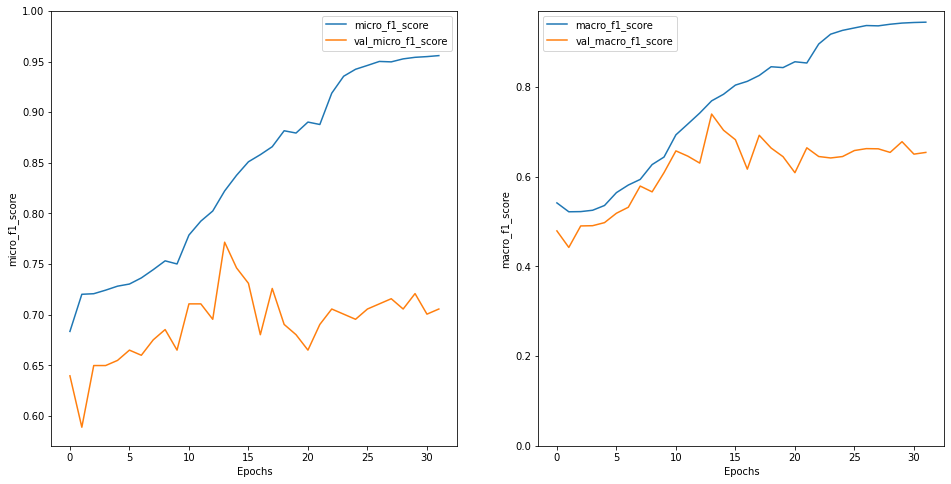

In [59]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'micro_f1_score')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'macro_f1_score')
plt.ylim(0,None)

In [60]:
#model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 1s 59ms/step - loss: 0.8670 - accuracy: 0.7407 - micro_f1_score: 0.7407 - macro_f1_score: 0.6723 0s - loss: 0.8895 - accuracy: 0.7266 - micro_f1_score: 0.7266 - macro_ - ETA: 0s - loss: 0.8257 - accuracy: 0.7526 - micro_f1_score: 0.7526 - macro_
Test Loss: 0.8670366406440735
Test Accuracy: 0.7407407164573669
Micro F1-Score: 0.7407407164573669
Macro F1-Score: 0.67227703332901


In [61]:
model.load_weights(checkpoint_path)
test_loss, test_acc, micro, macro = model.evaluate(testtitle, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Micro F1-Score:', micro)
print('Macro F1-Score:', macro)

19/19 [==============================] - 1s 59ms/step - loss: 0.8291 - accuracy: 0.7374 - micro_f1_score: 0.7374 - macro_f1_score: 0.6605
Test Loss: 0.8290913105010986
Test Accuracy: 0.7373737096786499
Micro F1-Score: 0.7373737096786499
Macro F1-Score: 0.6604927182197571
